In [2]:
import sys
print(sys.executable)

C:\Users\metal\anaconda3\python.exe


In [7]:
conda install -c conda-forge wordcloud=1.6.0 

Solving environment: ...working... failed with initial frozen solve. Retrying with flexible solve.
Solving environment: ...working... done

## Package Plan ##

  environment location: C:\Users\metal\anaconda3

  added / updated specs:
    - wordcloud=1.6.0


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    certifi-2019.11.28         |           py37_0         148 KB  conda-forge
    conda-4.8.3                |   py37hc8dfbb8_1         3.1 MB  conda-forge
    python_abi-3.7             |          1_cp37m           4 KB  conda-forge
    wordcloud-1.6.0            |   py37hfa6e2cd_0         186 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         3.4 MB

The following NEW packages will be INSTALLED:

  python_abi         conda-forge/win-64::python_abi-3.7-1_cp37m
  wordcloud          conda-forge/win-64::wo



==> WARNING: A newer version of conda exists. <==
  current version: 4.8.2
  latest version: 4.8.3

Please update conda by running

    $ conda update -n base -c defaults conda




In [8]:
# Import basic packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

!pip install tweepy

# Import other relevant packages
import tweepy
import re
import math
import string
import pickle
from urllib.request import urlopen
from string import punctuation
from joblib import dump, load
from skimage import io
from wordcloud import WordCloud, STOPWORDS

# Import and download NLP functions
import nltk
from nltk.corpus import stopwords
from nltk.corpus import wordnet as wn
from nltk.tokenize import word_tokenize
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

# Import sklearn functions
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc

# Import estimators
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier, Perceptron, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier

# Import streamlined methodology methods
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator
from sklearn.model_selection import GridSearchCV
from sklearn.externals import joblib

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\metal\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\metal\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\metal\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\wordnet.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\metal\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping taggers\averaged_perceptron_tagger.zip.
C:\Users\metal\anaconda3\lib\site-packages\sklearn\externals\joblib\__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize thos

In [9]:
def print_balance(df, col='senti'):
    if type(df) == pd.DataFrame:
        counts = df[col].value_counts(normalize=True)
    else:
        labels, counts = np.unique(y_test, return_counts=True)
        counts = dict(zip(labels, counts / len(y_test)))

    print('This dataset contains {0} negative tweets ({1:.1%})'.format(int(counts[0]*len(df)), counts[0]))
    print('This dataset contains {0} neutral tweets ({1:.1%})'.format(int(counts[2]*len(df)), counts[2]))
    print('This dataset contains {0} positive tweets ({1:.1%})'.format(int(counts[4]*len(df)), counts[4]))
    return counts

def balance(df, col='senti', weights=(1, 1, 1)):
    # Get the number of observations with each classification
    counts = df[col].value_counts(normalize=True)

    # Get the smallest number of observations for a sentiment label
    minNum = int(counts.min() * len(df))

    # Split the observations by sentiment and keep the same number of observations for each
    df_neg = df[df.senti == 0].iloc[:int(minNum*weights[0]), :]
    df_neu = df[df.senti == 2].iloc[:int(minNum*weights[1]), :]
    df_pos = df[df.senti == 4].iloc[:int(minNum*weights[2]), :]

    # Combine observations back into one dataframe 
    df_bal = pd.concat([df_neg, df_neu, df_pos])
    return df_bal

def clean_sentiment(s):
    '''
    This function cleans the sentiment label for tweets in the Sanders Analytics dataset.
    
    Inputs: string (sentiment label : {'negative', 'neutral', 'positive'})
    Outputs: integer (sentiment label : {0, 2, 4})
    '''
    if s == 'positive':
        return 4
    elif s == 'negative':
        return 0
    else:
        return 2

def preprocessTweets(text):
    text = str(text)
    text = text.translate(str.maketrans('', '', string.punctuation))    # Remove punctuation
    text = re.sub('((www\.[^\s]+)|(https?://[^\s]+))', 'URL', text)     # Remove URLs
    text = re.sub('@[^\s]+', 'AT_USER', text)                           # Remove usernames
    return text


class ClfSwitcher(BaseEstimator):

    def __init__(self, estimator=SVC()):
        """
        A Custom BaseEstimator that can switch between classifiers.
        :param estimator: sklearn object - The classifier
        """ 

        self.estimator = estimator

    def fit(self, X, y=None, **kwargs):
        self.estimator.fit(X, y)
        return self

    def predict(self, X, y=None):
        return self.estimator.predict(X)

    def predict_proba(self, X):
        return self.estimator.predict_proba(X)

    def score(self, X, y):
        return self.estimator.score(X, y)

In [10]:
data1 = pd.read_csv('C:/Users/metal/OneDrive/Desktop/FinalizedFull.csv').rename(columns={'tweet':'text'})
data1.head()

,text,senti
0,@united UA5396 can wait for me. I'm on the gro...,0
1,I hate Time Warner! Soooo wish I had Vios. Can...,0
2,"@united Oh, we are sure it's not planned, but ...",0
3,Tom Shanahan's latest column on SDSU and its N...,2
4,Found the self driving car!! /IWo3QSvdu2,2


In [11]:
# Check the balance of the dataset
counts1 = print_balance(data1)

This dataset contains 377 negative tweets (37.8%)
This dataset contains 239 neutral tweets (24.0%)
This dataset contains 381 positive tweets (38.2%)


In [12]:
# Read in the dataset
data2 = pd.read_csv('https://raw.githubusercontent.com/zfz/twitter_corpus/master/full-corpus.csv')[['Sentiment', 'TweetText']].rename(columns={'Sentiment':'senti', 'TweetText':'text'})

# Drop all spanish observations
data2 = data2[data2.senti != 'irrelevant']

# Clean the sentiment labels
data2['senti'] = data2['senti'].apply(clean_sentiment)

data2.head()

,senti,text
0,4,Now all @Apple has to do is get swype on the i...
1,4,@Apple will be adding more carrier support to ...
2,4,Hilarious @youtube video - guy does a duet wit...
3,4,@RIM you made it too easy for me to switch to ...
4,4,I just realized that the reason I got into twi...


In [13]:
# Check the balance of the dataset
counts2 = print_balance(data2)

This dataset contains 572 negative tweets (16.7%)
This dataset contains 2333 neutral tweets (68.1%)
This dataset contains 519 positive tweets (15.2%)


In [14]:
# Concatenate both training sets and preprocess tweets
train = pd.concat([data1, data2])
train['text'] = train['text'].apply(preprocessTweets)

# Check the balance of the dataset
train_counts = print_balance(train)

This dataset contains 949 negative tweets (21.5%)
This dataset contains 2572 neutral tweets (58.2%)
This dataset contains 900 positive tweets (20.4%)


In [15]:
# Create an adjusted dataset where there are twice as many neutral tweets as positive or negative tweets
train_adj = balance(train, weights=(1, 1.5, 1))

# Check the adjusted of the dataset
train_counts = print_balance(train_adj)

# Create train and test sets
X_train, X_test, y_train, y_test = train_test_split(train_adj.text.values, train_adj.senti.values, random_state=637)

This dataset contains 900 negative tweets (28.6%)
This dataset contains 1350 neutral tweets (42.9%)
This dataset contains 900 positive tweets (28.6%)


In [16]:
# Create train and test sets
X_train, X_test, y_train, y_test = train_test_split(train.text.values, train.senti.values, random_state=637)

In [17]:
# Split the test set into two equal parts
X_test_bal, X_test_full, y_test_bal, y_test_full = train_test_split(X_test, y_test, test_size=0.5, random_state=637)

# See composition of unbalanced test set
print('\033[1mComposition of unbalanced test set:\033[0m')
print_balance(y_test_full)

# Create the balanced dataframe
test_bal = pd.DataFrame({'text':X_test_bal, 'senti':y_test_bal})
test_bal = balance(test_bal)
print('\n\033[1mComposition of balanced test set:\033[0m')
print_balance(test_bal)

X_test_bal = test_bal.text.values
y_test_bal = test_bal.senti.values

Composition of unbalanced test set:
This dataset contains 111 negative tweets (20.2%)
This dataset contains 327 neutral tweets (59.1%)
This dataset contains 114 positive tweets (20.7%)

Composition of balanced test set:
This dataset contains 114 negative tweets (33.3%)
This dataset contains 114 neutral tweets (33.3%)
This dataset contains 114 positive tweets (33.3%)


In [18]:
class TwitterSentimentModel():

    def __init__(self):
        pass

    def fit(self, X, y, classifier='all', cv=10, verbose=False):

        X = [preprocessTweets(t) for t in X]

        # Create the Pipeline object
        pipeline = Pipeline([
            ('tfidf', TfidfVectorizer(lowercase=True, 
                                strip_accents='ascii',
                                stop_words='english')),
            ('clf', ClfSwitcher())
        ])

        # this is where we define the values for GridSearchCV to iterate over
        parameters = [
            { # For SVM, the best accuracy was 70.67% on the test data (71.36% on training data) -- runs in about 60 sec
             'clf__estimator': [SVC(random_state=637)],
             'tfidf__ngram_range': [(1, 1), (1, 2)],
             'tfidf__norm' : ['l1', 'l2'],
             'clf__estimator__kernel' : ['rbf', 'linear', 'sigmoid'],
            },
            { # For Naive Bayes, the best accuracy was 68.30% on the test data (70.12% on training data) -- runs in about 5.1 sec
             'clf__estimator': [MultinomialNB()],
             'tfidf__ngram_range': [(1, 1), (1, 2)],
             'tfidf__norm' : ['l1', 'l2'],
             'clf__estimator__fit_prior' : [True, False],
             'clf__estimator__alpha' : np.arange(0.1, 1.5, 16)
            },
            { # For SGD, the best accuracy was 72.15% on the test data (72.74% on training data) -- runs in about 34.3 sec
             'clf__estimator': [SGDClassifier(random_state=637, n_jobs=-1)],
             'tfidf__ngram_range': [(1, 1), (1, 2)],
             'tfidf__norm' : ['l1', 'l2'],
             'clf__estimator__loss': ['log', 'modified_huber'],
             'clf__estimator__penalty': ['l1', 'l2', 'elasticnet']
            },
            { # For KNN, the best accuracy was 62.96% on the test data (64.25% on training data) -- runs in about 35.3 sec
             'clf__estimator': [KNeighborsClassifier()],
             'tfidf__ngram_range': [(1, 1), (1, 2)],
             'tfidf__norm' : ['l1', 'l2'],
             'clf__estimator__leaf_size': [10, 30, 50],
             'clf__estimator__n_neighbors' : [1, 5, 10, 20]
            },
            { # For Random Forests, the best accuracy was 68.30% on the test data (69.13% on training data) -- runs in about 1.7 min (102 sec)
             'clf__estimator': [RandomForestClassifier(random_state=637, n_jobs=-1)],
             'tfidf__ngram_range': [(1, 1)],
             'tfidf__norm' : ['l1', 'l2'],
             'clf__estimator__criterion' : ['gini', 'entropy'],
             'clf__estimator__min_samples_leaf' : [1, 5],
             'clf__estimator__max_depth' : [5, 25, None]
            },
            { # For Perceptron, the best accuracy was 69.93% on the test data (69.87% on training data) -- runs in about 11.2 sec
             'clf__estimator': [Perceptron(random_state=637, n_jobs=-1)],
             'tfidf__ngram_range': [(1, 1), (1, 2)],
             'tfidf__norm' : ['l1', 'l2'],
             'clf__estimator__penalty': ['l1', 'l2', 'elasticnet']
            },
            { # For Logistic Regression, the best accuracy was 69.48% on the test data (70.12% on training data) -- runs in about 14.1 sec
             'clf__estimator': [LogisticRegression(random_state=637, n_jobs=-1)],
             'tfidf__ngram_range': [(1, 1), (1, 2)],
             'tfidf__norm' : ['l1', 'l2'],
             'clf__estimator__C' : np.arange(0.5, 1.5, 11)
            }]
        
        param_dict = {'SVM' : 0, 
                      'Naive Bayes' : 1,
                      'SGD' : 2,
                      'KNN' : 3,
                      'Random Forest' : 4,
                      'Perceptron' : 5,
                      'Logistic Regression' : 6}

        if classifier != 'all':
            parameters = parameters[param_dict[classifier]]
        else:
            pass

        # do 10-fold cross validation for each of the combinations of the above params
        self.grid = GridSearchCV(pipeline, cv=cv, param_grid=parameters, n_jobs=-1, verbose=1)
        self.grid.fit(X, y)

        # summarize results
        print("\nBest Model: {0:.2%} using {1}".format(self.grid.best_score_, self.grid.best_params_))
        print('\n')
        self.compile_results(X, y)


    def compile_results(self, X, y):
        self.means = self.grid.cv_results_['mean_test_score']
        self.stds = self.grid.cv_results_['std_test_score']
        self.params = self.grid.cv_results_['params']

        # Define the estimator tested
        estimators = {SVC : 'SVC',
                MultinomialNB : 'Naive Bayes',
                SGDClassifier : 'SGD',
                KNeighborsClassifier : 'KNN',
                RandomForestClassifier : 'Random Forest',
                Perceptron : 'Perceptron',
                LogisticRegression : 'Logistic Regression'}

        # Organize the estimator performance into a data frame
        data = {'Estimator':[estimators[type(e['clf__estimator'])] for e in self.params],
                'score': self.means,
                'ngram_range': [e['tfidf__ngram_range'] for e in self.params],
                'tfidf__norm' : [e['tfidf__norm'] for e in self.params],
                'computing_time' : self.grid.cv_results_['mean_fit_time'],
                'estimator_obj' : [e['clf__estimator'] for e in self.params]}

        self.all_results = pd.DataFrame(data=data)

        # Get the best performing model for each estimator
        idx = self.all_results.groupby(['Estimator'])['score'].transform(max) == self.all_results['score']
        self.results = self.all_results[idx]
        idx = self.results.groupby(['Estimator'])['computing_time'].transform(max) == self.results['computing_time']
        self.results = self.results[idx].set_index('Estimator')


    def set_uncertainty(self, X, y):
        # Find the standard error on aggregate sentiment scores
        print('Calculating uncertainty for aggregate sentiment scores...')
        self.agg_errs, self.agg_true_means, self.agg_pred_means = self.agg_sent_score(X, y,
                                                                                      n_bootstraps=1000,
                                                                                      bootstrap_size=1000,
                                                                                      verbose=True)
        self.agg_me = self.agg_errs.mean()     # Mean average error in aggregated sentiment scores
        self.agg_unc = model.agg_errs.std()*2  # Uncertainty in aggregated sentiment scores (95% confidence)
        print('Done! Aggregate sentiment uncertainty = {0:.4f}'.format(self.agg_unc))


    def print_all_results(self):
        for mean, stdev, param in zip(self.means, self.stds, self.params):
            param = param.copy()
            del param['clf__estimator']
            print("Mean: %f Stdev:(%f) with: %r" % (mean, stdev, param))


    def score(self, X, y, verbose=False):
        return self.grid.score(X, y)


    def predict(self, X, vebose=False):
        return self.grid.predict(X)


    def predict_proba(self, X):
        return self.grid.predict_proba(X)


    def predict_agg(self, X, verbose=False):
        agg_sent = ((self.grid.predict(X) - 2) / 2).mean()
        agg_unc = self.agg_unc * np.sqrt(1000 / len(X))
        if verbose: print('(scale from -1 to 1) Aggregated sentiment score: {0:.2f} \u00B1 {1:.2f}\n'.format(agg_sent, agg_unc))
        return agg_sent, self.agg_unc


    def classification_report(self, X, y):
        y_preds = self.predict(X)
        print(classification_report(y, y_preds))


    def confusion_matrix(self, X, y):
        y_preds = self.predict(X)
        print('\nconfusion matrix: \n',confusion_matrix(y,y_preds), '\n')


    def estimator_performance(self, metric='score', ylim=(0.6, 0.75)):
        # Plot the performance
        fig, ax = plt.subplots(figsize=(7, 5))
        self.results.sort_values(by=metric, ascending=False).plot.bar(y=metric, ax=ax, rot=45, legend=False)
        ax.set_ylim(ylim);
        ax.set_title('Model Performance for Each Estimator', fontsize='x-large')
        ax.set_xlabel('Estimator Type', fontsize='x-large')

        if metric == 'score':
            ax.set_ylabel('Max model accuracy', fontsize='x-large')
        elif metric == 'computing_time':
            ax.set_ylabel('Mean time to fit model (s)', fontsize='x-large')
        else:
            pass
        fig.show()
        return fig


    def sentiment_performance(self, X, y, ylim=0.5):
        # Get results
        report = classification_report(y, self.predict(X), output_dict=True)
        neg_results = list(report['0'].values())[:3]
        neu_results = list(report['2'].values())[:3]
        pos_results = list(report['4'].values())[:3]

        # Set position of bar on X axis
        barWidth = 0.25
        x1 = np.arange(len(neg_results))
        x2 = [x + barWidth for x in x1]
        x3 = [x + barWidth for x in x2]

        # Plot the performance
        fig, ax = plt.subplots(figsize=(7, 5))

        # Make the plot
        ax.bar(x1, neg_results, color='indianred', width=barWidth, edgecolor='white', label='Negative')
        ax.bar(x2, neu_results, color='sandybrown', width=barWidth, edgecolor='white', label='Neutral')
        ax.bar(x3, pos_results, color='mediumseagreen', width=barWidth, edgecolor='white', label='Postiive')
        ax.set_xticks(x2)
        ax.set_xticklabels(('Precision', 'Recall', 'F1 Score'), fontsize='x-large')
        ax.set_ylim(0, 1)
        ax.set_title('Best Estimator Performance on Different Sentiments', fontsize='x-large')

        ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
        fig.show();
        return report


    def plot_roc(self, X_test, y_test):
        y_score = self.predict_proba(X_test)

        # Reshape y_test
        ytest = []
        for i in y_test:
            if i == 0:
                ytest.append([1, 0, 0])
            elif i == 2:
                ytest.append([0, 1, 0])
            else:
                ytest.append([0, 0, 1])
        y_test = np.array(ytest)

        # Compute ROC curve and ROC area for each class
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        for i in range(3):
            fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])

        # Compute micro-average ROC curve and ROC area
        fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
        roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

        fig, ax = plt.subplots(figsize=(7, 7))
        for i, title in enumerate(['Negative', 'Neutral', 'Positive']):
            ax.plot(fpr[i], tpr[i], label=title + ' tweets (AUC = %0.2f)' % roc_auc[i])
        ax.plot([0, 1], [0, 1], color='black', linestyle='--')
        ax.set_xlim([0.0, 1.0])
        ax.set_ylim([0.0, 1.0])
        ax.set_xlabel('False Negative Rate', fontsize='x-large')
        ax.set_ylabel('True Positive Rate', fontsize='x-large')
        ax.set_title('ROC Curve of Each Sentiment', fontsize='xx-large')
        ax.legend(loc="lower right")
        fig.show()
        return fig


    def agg_sent_score(self, X, y, n_bootstraps=1000, bootstrap_size=1000, verbose=False):
        np.random.seed(637)
        true_means, pred_means, errs = np.ones(n_bootstraps), np.ones(n_bootstraps), np.ones(n_bootstraps)
        for i in range(n_bootstraps):
            if verbose:
                if not (i+1)%(n_bootstraps//5): print('{0:.0f}% done'.format((i+1)/(n_bootstraps//100)))
            ind = np.random.randint(0, len(X), int(bootstrap_size))
            X_boot = X[ind]
            y_boot = y[ind]
            y_pred = self.grid.predict(X_boot)

            # Standardize predictions to a -1 to 1 scale
            y_boot = (y_boot - 2) / 2
            y_pred = (y_pred - 2) / 2

            true_means.put(i, y_pred.mean())
            pred_means.put(i, y_boot.mean())
            errs.put(i, y_boot.mean() - y_pred.mean())

        self.mean_agg_error = errs.mean()
        return errs, true_means, pred_means


    def agg_sent_hist(self, X, y, n_bootstraps=1000, bootstrap_size=1000, verbose=False):
        errs, true_means, pred_means = self.agg_sent_score(X, y, n_bootstraps, bootstrap_size, verbose)
        fig, ax = plt.subplots(figsize=(7, 7))
        ax.hist(errs)
        plt.axvline(errs.mean(), color='k', linestyle='dashed')
        ax.set_xlabel('Aggregated Sentiment Error', fontsize='xx-large')
        ax.set_title('Sentiment Score Prediction Error', fontsize='xx-large')
        fig.show()
        return fig


    def agg_sent_plot(self, X, y, n_bootstraps=1000, bootstrap_size=1000, verbose=False):
        errs, true_means, pred_means = self.agg_sent_score(X, y, n_bootstraps, bootstrap_size, verbose)
        fig, ax = plt.subplots(figsize=(7, 7))
        ax.scatter(true_means, pred_means)
        ax.plot(true_means, true_means, color='red')
        ax.set_ylabel('Predicted Sentiment Score', fontsize='xx-large')
        ax.set_xlabel('Actual Sentiment Score', fontsize='xx-large')
        fig.show()
        return fig

    def word_cloud(self, tweets, labels=None, sentiment=None, showfig=True, mask=None, ngrams_range=(1, 2)):
        sent_dict = {'negative':0,
                    'neutral':2,
                    'positive':4}

        tweets = [preprocessTweets(tweet) for tweet in tweets]
        if labels is None:
            labels = self.predict(tweets)

        # Get desired tweets
        if sentiment:
            tweets = [tweets[i] for i in np.where(labels == sent_dict[sentiment])[0]]

        # Get vocabulary of tweets
        tfidf = TfidfVectorizer(lowercase=True, 
                                strip_accents='ascii',
                                stop_words='english',
                                ngram_range=ngrams_range)
        tfidf.fit(tweets)
        
        vocabulary = tfidf.vocabulary_
        weights = tfidf.idf_
        weight_dict = {v:w for v, w, in zip(vocabulary, weights)}

        # Create Word Cloud
        word_cloud = WordCloud(width=2000,
                                height=1000,
                                max_font_size=200, 
                                background_color="white",
                                max_words=100,
                                mask=mask,
                                contour_width=1,
                                stopwords=STOPWORDS.add('https'))
        word_cloud.generate_from_frequencies(weight_dict)

        # Plot the Word Cloud
        fig = plt.figure(figsize=(10,10))
        plt.imshow(word_cloud, interpolation="hermite")
        plt.axis("off")     
        if showfig: fig.show()
        return fig

In [22]:
if False:
    model = TwitterSentimentModel()
    model.fit(X_train, y_train, classifier='SGD')
    model.set_uncertainty(X_test, y_test)

    with open("trained_model.pickle", "wb") as f:
        pickle.dump(model, f)

In [21]:
model_location = 'https://github.com/akshay722/Opinion-analysis/blob/master/trained_model.pickle?raw=true'
model = load(urlopen(model_location))

C:\Users\metal\anaconda3\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator TfidfTransformer from version 0.22.2.post1 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\metal\anaconda3\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator TfidfVectorizer from version 0.22.2.post1 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\metal\anaconda3\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator SVC from version 0.22.2.post1 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\metal\anaconda3\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator Pipeline from version 0.22.2.post1 when using version 0.22.1. This might lead to breaking code or invalid resu

In [23]:
acc = model.score(X_test_full, y_test_full), model.score(X_test_bal, y_test_bal) 
print('accuracy on original test set: {0:.2%}'.format(acc[0])) 
print('accuracy on balanced test set: {0:.2%}'.format(acc[1])) 

accuracy on original test set: 77.94%
accuracy on balanced test set: 70.18%


C:\Users\metal\anaconda3\lib\site-packages\ipykernel_launcher.py:254: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


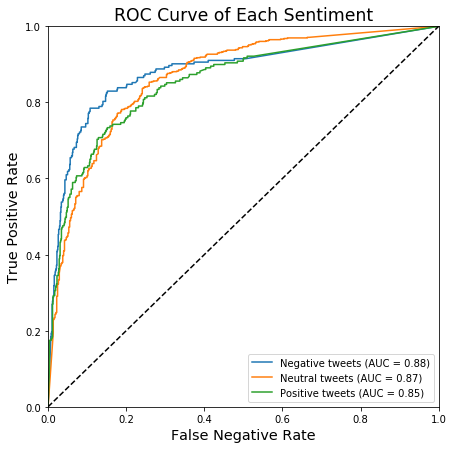

In [24]:
fig = model.plot_roc(X_test, y_test)
fig.savefig('roc.png')

C:\Users\metal\anaconda3\lib\site-packages\ipykernel_launcher.py:288: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


Mean aggregate score error: 0.00407


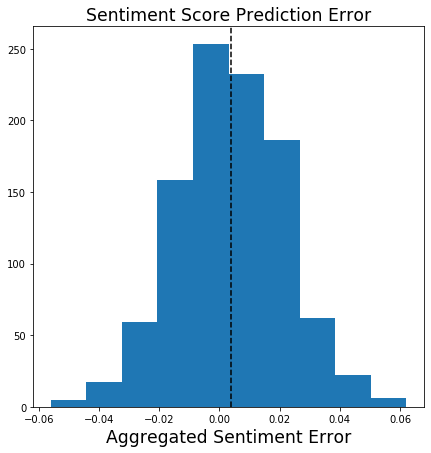

In [25]:
fig = model.agg_sent_hist(X_test, y_test)
print('Mean aggregate score error: {0:.5f}'.format(model.agg_me))
fig.savefig('agg_error_hist.png')

C:\Users\metal\anaconda3\lib\site-packages\ipykernel_launcher.py:299: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


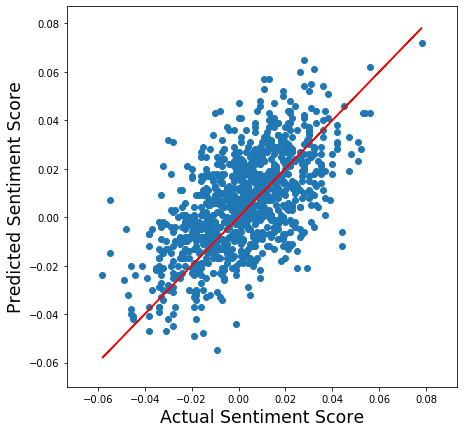

In [26]:
fig = model.agg_sent_plot(X_test, y_test)
fig.savefig('agg_error_scatter.png')

C:\Users\metal\anaconda3\lib\site-packages\ipykernel_launcher.py:214: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


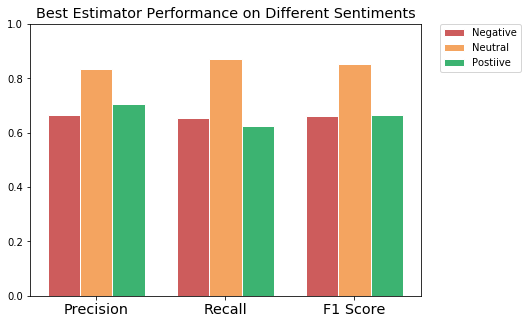

In [27]:
result_dict = model.sentiment_performance(X_test_full, y_test_full)

In [28]:
print('\033[1m\tClassification report on the Original Test Set\033[0m')
model.classification_report(X_test_full, y_test_full)

#print('\n\n\033[1m\tClassification report on the Balanced Test Set\033[0m')
#model.classification_report(X_test_bal, y_test_bal);

	Classification report on the Original Test Set
              precision    recall  f1-score   support

           0       0.67      0.65      0.66       104
           2       0.83      0.87      0.85       334
           4       0.71      0.63      0.66       115

    accuracy                           0.78       553
   macro avg       0.74      0.72      0.73       553
weighted avg       0.78      0.78      0.78       553



C:\Users\metal\anaconda3\lib\site-packages\ipykernel_launcher.py:184: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


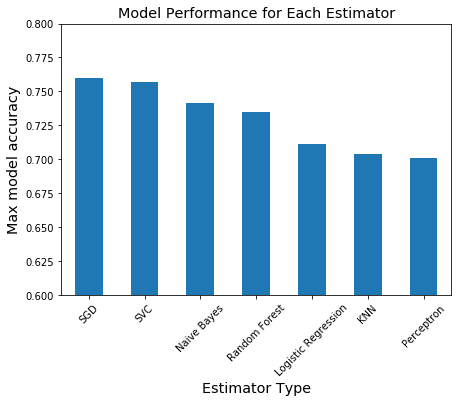

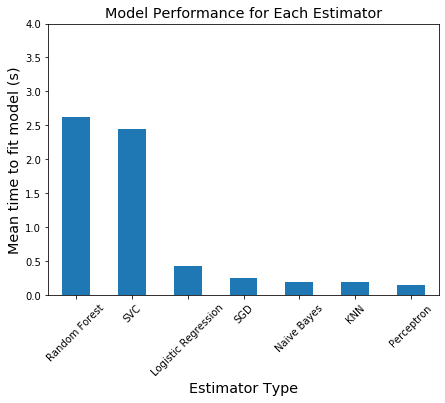

In [29]:
fig = model.estimator_performance('score', ylim=(0.6, 0.8))
fig.savefig('estimator_performance.png')

fig = model.estimator_performance('computing_time', ylim=(0, 4));
fig.savefig('estimator_time.png')

In [30]:
model.results.loc["Naive Bayes", "computing_time"] / model.results.loc["SGD", "computing_time"] 

0.782425870250037

In [31]:
model.results

,score,ngram_range,tfidf__norm,computing_time,estimator_obj
Estimator,,,,,
SVC,0.756851,"(1, 2)",l2,2.443943,"SVC(C=1.0, break_ties=False, cache_size=200, c..."
Naive Bayes,0.741470,"(1, 2)",l1,0.198657,"MultinomialNB(alpha=1.0, class_prior=None, fit..."
SGD,0.759862,"(1, 2)",l2,0.253898,"SGDClassifier(alpha=0.0001, average=False, cla..."
KNN,0.704060,"(1, 2)",l2,0.196545,"KNeighborsClassifier(algorithm='auto', leaf_si..."
Random Forest,0.735143,"(1, 1)",l2,2.621815,"RandomForestClassifier(bootstrap=True, ccp_alp..."
Perceptron,0.701358,"(1, 1)",l2,0.157811,"Perceptron(alpha=0.0001, class_weight=None, ea..."
Logistic Regression,0.711621,"(1, 1)",l2,0.424493,"LogisticRegression(C=1.0, class_weight=None, d..."


In [33]:
model.grid.predict_proba(['I love the colour red!'])

array([[0., 0., 1.]])

In [38]:
model.grid.predict_proba(['Red colour is pretty much indifferent to me'])

array([[0.35511795, 0.1159751 , 0.52890695]])

In [39]:
model.grid.predict_proba(['I hate the colour red!'])

array([[1., 0., 0.]])

C:\Users\metal\anaconda3\lib\site-packages\ipykernel_launcher.py:341: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


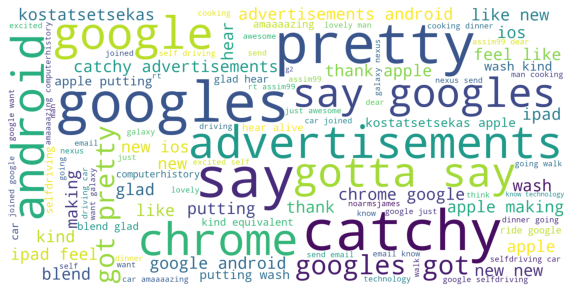

In [40]:
fig = model.word_cloud(X_train, y_train, 'positive')
fig.savefig('wc_train.png')

In [41]:
# Get image to use as mask for word cloud
url = 'https://github.com/akshay722/Opinion-analysis/blob/master/figures/twitter_mask.png?raw=true'
twitter_mask = io.imread(url)

C:\Users\metal\anaconda3\lib\site-packages\ipykernel_launcher.py:341: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


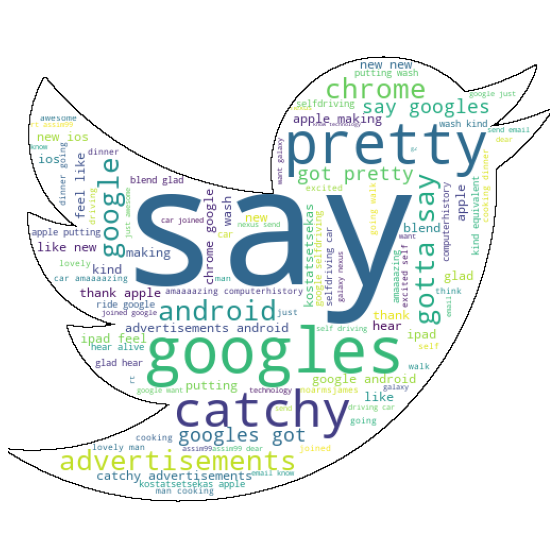

In [42]:
fig = model.word_cloud(X_train, y_train, 'positive', mask=twitter_mask)
fig.savefig('wc_train_pos.png')

C:\Users\metal\anaconda3\lib\site-packages\ipykernel_launcher.py:341: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


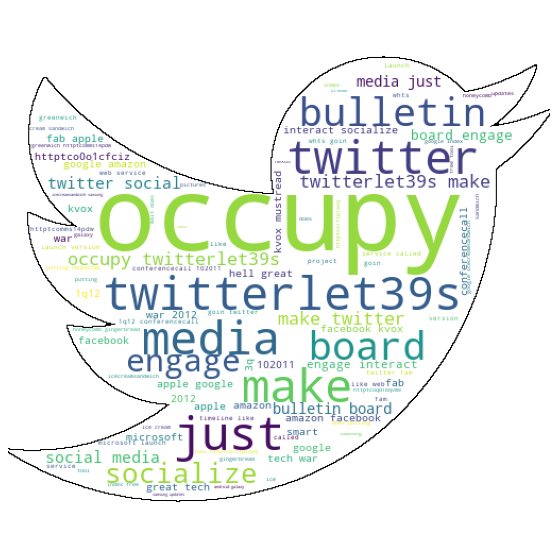

In [43]:
fig = model.word_cloud(X_train, y_train, 'neutral', mask=twitter_mask)
fig.savefig('wc_train_neu.png')

C:\Users\metal\anaconda3\lib\site-packages\ipykernel_launcher.py:341: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


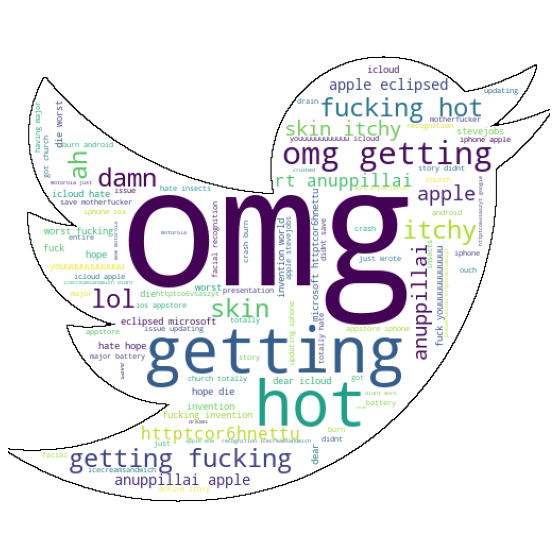

In [44]:
fig = model.word_cloud(X_train, y_train, 'negative', mask=twitter_mask)
fig.savefig('wc_train_neg.png')

In [45]:
# Developer keys
consumer_key = 'WKZJjQRJBJE6ZXAy8tiBotVV0'
consumer_key_secret = 'dcy3B146XiVTYzcgYO3kqjMS3xiVfqYdUNmRAGftThsiwek36S'

# Secret token (not used anywhere)
access_token_key = '2954379412-yKnvAzEL0KTQUxZPMHQHgwTC7WNbPB7w4AOMrPO'
access_token_key_secret = '9dwQjP3WqnvIclgcnilIqTz27vdRPQgSPfOKKCA7Y4mot'

# Initialize api instance
auth = tweepy.OAuthHandler(consumer_key, consumer_key_secret)
auth.set_access_token(access_token_key, access_token_key_secret)
twitter_api = tweepy.API(auth)
print('Authorization successful:', twitter_api != None)

Authorization successful: True


In [46]:
def getTweets(search_term, num_tweets=1000, rts=False, date=None):
    if not rts:
            search_term += '-filter:retweets'       # Exclude retweets from search
    
    all_tweets = []
    idset = {}
    max_id=None
    while len(idset) < num_tweets:
        if date is not None:                            # Get tweets at or before a certain date
            fetched_tweets = twitter_api.search(q=search_term, count=num_tweets, lang='en', until=date, max_id=max_id, result_type='recent')
            if not fetched_tweets:                  # If certain date was more than a week ago
                fetched_tweets = twitter_api.search(q=search_term, count=num_tweets, lang='en', max_id=max_id, result_type='recent')
        else:                                       # Get most recent tweets
            fetched_tweets = twitter_api.search(q=search_term, count=num_tweets, lang='en', max_id=max_id, result_type='recent')

        idlist = [status.id for status in fetched_tweets]
        idset = set(list(idset) + idlist)
        max_id = min(idset)
        all_tweets += list(fetched_tweets)

    print("Fetched {0} tweets about {1}".format(len(all_tweets), search_term))
    return [status.text for status in all_tweets]

In [47]:
# Make query
search_term = 'coronavirus'

testTweets = getTweets(search_term)
for tweet in testTweets[:5]:
    print('\n', tweet)

Fetched 1100 tweets about coronavirus-filter:retweets

 We have taken steps to ensure that we are all cross-#trained to some degree and in the worst case #scenario, should… https://t.co/sb4NcGKNzm

 Infection rate in the greater Houston area. #TexasCOVID #coronavirus https://t.co/QXYHeAo28u

 This very difficult decision was made following the recommendations of government authorities including the Center… https://t.co/HZfiDmaobb

 @DanielleNicki It’s like it’s all life or death to me now. I’ve gotta hit *somewhere* before Covid gets me!! 😅 Who… https://t.co/GBZsCpxChq

 Karma...
A GOP sheriff vowed not to enforce Arizona’s coronavirus restrictions. Now he’s tested positive. https://t.co/BhURq6QWoM


In [48]:
for tweet in testTweets[:5]:
    print(model.grid.predict_proba([tweet]))

model.predict_agg(testTweets, verbose=True);

[[0.53642481 0.46357519 0.        ]]
[[0.23376323 0.71703036 0.04920641]]
[[0.33892541 0.66107459 0.        ]]
[[0.68545728 0.         0.31454272]]
[[0.32226809 0.67306772 0.00466419]]
(scale from -1 to 1) Aggregated sentiment score: -0.01 ± 0.05



C:\Users\metal\anaconda3\lib\site-packages\ipykernel_launcher.py:341: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
C:\Users\metal\anaconda3\lib\site-packages\ipykernel_launcher.py:341: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
C:\Users\metal\anaconda3\lib\site-packages\ipykernel_launcher.py:341: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
C:\Users\metal\anaconda3\lib\site-packages\ipykernel_launcher.py:341: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


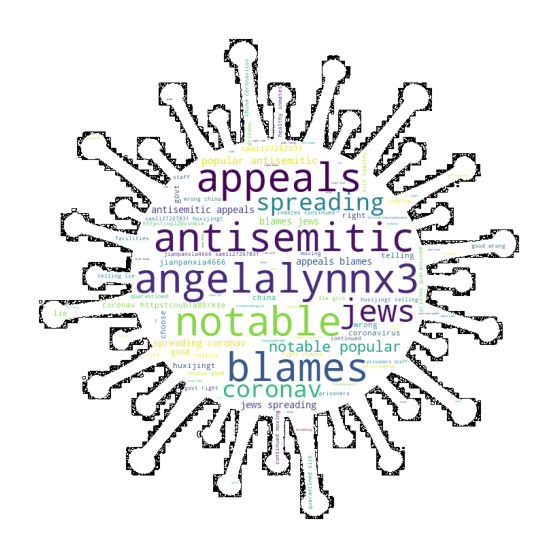

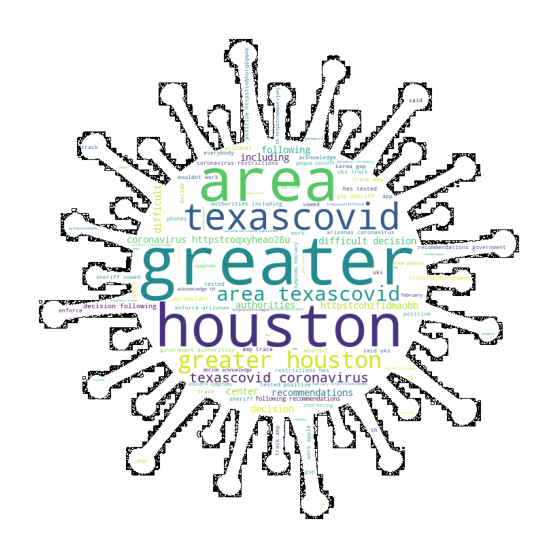

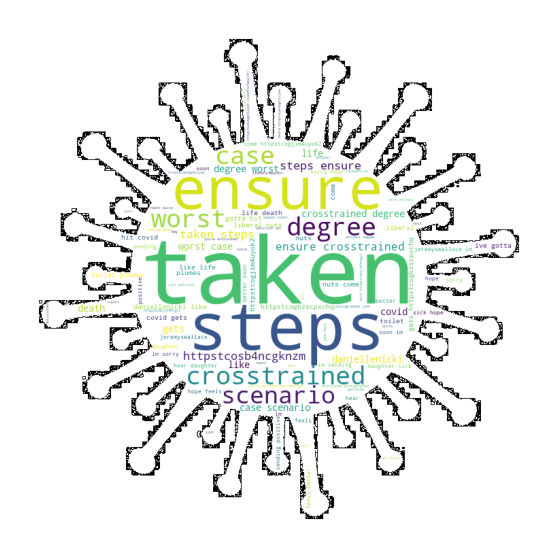

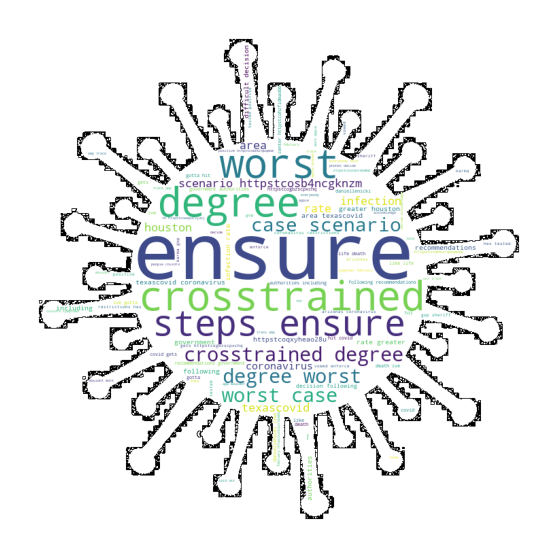

In [50]:
url = 'https://github.com/akshay722/Opinion-analysis/blob/master/figures/virus_mask.jpg?raw=True'
virus_mask = io.imread(url)

fig = model.word_cloud(testTweets, sentiment='positive', mask=virus_mask)
fig.savefig('wc_corona_pos.png')
fig = model.word_cloud(testTweets, sentiment='neutral', mask=virus_mask)
fig = model.word_cloud(testTweets, sentiment='negative', mask=virus_mask)
fig = model.word_cloud(testTweets, mask=virus_mask)

Fetched 1100 tweets about love-filter:retweets
(scale from -1 to 1) Aggregated sentiment score: 0.83 ± 0.05



C:\Users\metal\anaconda3\lib\site-packages\ipykernel_launcher.py:341: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


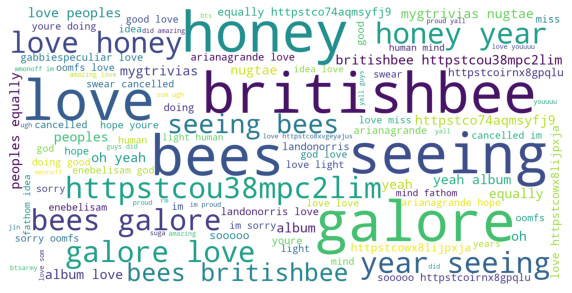

In [51]:
tweets = getTweets('love')
model.predict_agg(tweets, verbose=True)
model.word_cloud(tweets, sentiment='positive');

Fetched 1100 tweets about hate-filter:retweets
(scale from -1 to 1) Aggregated sentiment score: -0.77 ± 0.05



C:\Users\metal\anaconda3\lib\site-packages\ipykernel_launcher.py:341: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


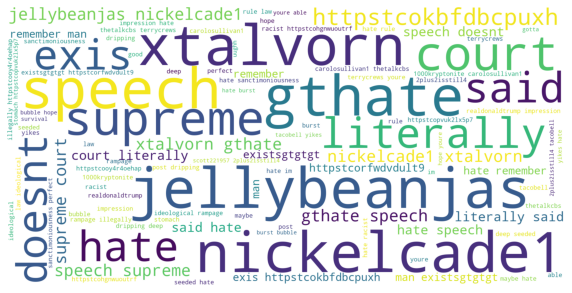

In [52]:
tweets = getTweets('hate')
model.predict_agg(tweets, verbose=True)
model.word_cloud(tweets, sentiment='negative');

In [ ]:
tweets = getTweets('bitcoin', date='06-018-2020')
model.predict_agg(tweets, verbose=True);

In [54]:
tweets = getTweets('reopen', rts=True)
model.predict_agg(tweets, verbose=True)

print('\n')
tweets = getTweets('economy', rts=True)
model.predict_agg(tweets, verbose=True)

print('\n')
tweets = getTweets('school', rts=True)
model.predict_agg(tweets, verbose=True)

print('\n')
tweets = getTweets('summer', rts=True)
model.predict_agg(tweets, verbose=True);

print('\n')
tweets = getTweets('future', rts=True)
model.predict_agg(tweets, verbose=True);

Fetched 1100 tweets about reopen
(scale from -1 to 1) Aggregated sentiment score: 0.01 ± 0.05



Fetched 1100 tweets about economy
(scale from -1 to 1) Aggregated sentiment score: 0.09 ± 0.05



Fetched 1100 tweets about school
(scale from -1 to 1) Aggregated sentiment score: 0.33 ± 0.05



Fetched 1100 tweets about summer
(scale from -1 to 1) Aggregated sentiment score: -0.03 ± 0.05



Fetched 1100 tweets about future
(scale from -1 to 1) Aggregated sentiment score: 0.09 ± 0.05



In [55]:
tweets = getTweets('Apple', rts=True)
model.predict_agg(tweets, verbose=True)

print('\n')
tweets = getTweets('Google', rts=True)
model.predict_agg(tweets, verbose=True)

print('\n')
tweets = getTweets('Facebook', rts=True)
model.predict_agg(tweets, verbose=True)

print('\n')
tweets = getTweets('Microsoft', rts=True)
model.predict_agg(tweets, verbose=True);

print('\n')
tweets = getTweets('Tesla', rts=True)
model.predict_agg(tweets, verbose=True);

Fetched 1100 tweets about Apple
(scale from -1 to 1) Aggregated sentiment score: -0.16 ± 0.05



Fetched 1100 tweets about Google
(scale from -1 to 1) Aggregated sentiment score: 0.04 ± 0.05



Fetched 1100 tweets about Facebook
(scale from -1 to 1) Aggregated sentiment score: 0.06 ± 0.05



Fetched 1017 tweets about Microsoft
(scale from -1 to 1) Aggregated sentiment score: 0.02 ± 0.05



Fetched 1100 tweets about Tesla
(scale from -1 to 1) Aggregated sentiment score: 0.05 ± 0.05



In [60]:
tweets = getTweets('Cryptocurrency', rts=True)
model.predict_agg(tweets, verbose=True)

print('\n')
tweets = getTweets('Bitcoin', rts=True)
model.predict_agg(tweets, verbose=True)

print('\n')
tweets = getTweets('Ethereum', rts=True)
model.predict_agg(tweets, verbose=True)

print('\n')
tweets = getTweets('Ripple', rts=True)
model.predict_agg(tweets, verbose=True)

print('\n')
tweets = getTweets('Rupee', rts=True)
model.predict_agg(tweets, verbose=True);

RateLimitError: [{'message': 'Rate limit exceeded', 'code': 88}]

In [61]:
tweets = getTweets('blue', rts=True)
model.predict_agg(tweets, verbose=True)

print('\n')
tweets = getTweets('red', rts=True)
model.predict_agg(tweets, verbose=True)

print('\n')
tweets = getTweets('green', rts=True)
model.predict_agg(tweets, verbose=True)

print('\n')
tweets = getTweets('yellow', rts=True)
model.predict_agg(tweets, verbose=True);

RateLimitError: [{'message': 'Rate limit exceeded', 'code': 88}]

In [ ]:
# 